In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import block_diag

plt.close('all')

Loading the data

In [2]:
data = np.load('data_point_land_1.npz', allow_pickle=True)

Meas = data['Meas'] #Landmark measurements
Uf = data['Uf'] #measured forward velocity (odometry)
Ua = data['Ua'] #measured angular velocity (odometry)
Q = data['Q']
Qturn = data['Qturn']
R = data['R']
Nland = data['Nland'] #number of Landmarks
Ts = data['Ts']
Wturn = data['wturn'] #treshold Wturn
Pose = data['Pose'] #data to be used only for comparison (x(t), y(t), theta(t) of the robot)
Landmarks = data['Landmarks'] #data to be used only for comparison (ith row corresponds to i+1th of landmark locations.)

In [3]:
range_land = Meas.item()['range'] #landmark ranges
angle_land = Meas.item()['angle']  #landmark angles
index_land = Meas.item()['land']  #landmark indices

Angle Wrapping Function

In [4]:
def angle_wrap(angle):
    angle = (angle + np.pi) % (2 * np.pi) - np.pi
    return angle

def innovation(M, xp):
    
    landmarks = M[:, 2]

    # take the predictions
    predicted_meas = np.zeros((len(landmarks), 2))
    
    for i in range(len(landmarks)):
        j = int(landmarks[i] - 1)

        lx = xp[n_upper + 2*j]
        ly = xp[n_upper + 2*j + 1]
        
        predicted_p = np.sqrt((lx - xp[0])**2 + (ly - xp[1])**2)
        predicted_alpha = angle_wrap(np.arctan2(ly - xp[1], lx - xp[0]) - xp[2])
        predicted_meas[i][0] = predicted_p
        predicted_meas[i][1] = predicted_alpha
    
    inn = M[:, :2] - predicted_meas
    return inn.reshape(-1,1)

Initialising

In [5]:
N = Uf.shape[0] #Number of odometry measurements

n_upper = 3 #upper system order: x,y,theta
n_lower = Nland.item()*2 #lower system order: 2 for every landmark (x,y)
n = n_upper + n_lower  #system order

x0 = np.zeros(n) #initial states
x0[0] = Pose[0,0] #x(0)
x0[1] = Pose[0,1] #y(0)
x0[2] = Pose[0,2] #theta(0)
#upper covariance
lambda_ = 1e-6
P_upper = lambda_ * np.eye(n_upper) #uncertainty of x,y,theta
upper_zeros = np.zeros((n_upper,n_lower))
#lower covariance
eta = 1000
P_lower = eta * np.eye(n_lower) #uncertainty landmarks
lower_zeros = np.zeros((n_lower,n_upper))
#Initial covariance
P0 = np.block([[P_upper,upper_zeros],
              [lower_zeros,P_lower]])


EKF loop

In [6]:
Xp = x0.copy()
Pp = P0.copy()
X_pred = np.empty((N,n))
P_pred = np.empty((N,n))
X_pred[0, :] = Xp

turn = Qturn[1][1]
straight = Q[1][1]


Q_straight = Q.copy()
switched = False

checked_landmarks = []
# wait_time = 7
counter = 1
Xp_lower = np.zeros(n_lower)
i = 1
while i < N:
    # Prediction
    
    X = Xp.copy()
    Xp = X + np.concatenate((Ts*np.array([Uf[i-1]*np.cos(X[2]), Uf[i-1]*np.sin(X[2]), Ua[i-1]]), Xp_lower))
       
    Xp[2] = angle_wrap(Xp[2])
    dUpper_dx = np.array([[1, 0, -Ts*Uf[i-1]*np.sin(X[2])],
                          [0, 1, Ts*Uf[i-1]*np.cos(X[2])],
                          [0, 0, 1]])
    dLower_dx = np.eye(n_lower)
    F = np.block([[dUpper_dx,upper_zeros],
                [lower_zeros,dLower_dx]])
    dupper_dw = np.array([[-Ts*np.cos(X[2]), 0],
                  [-Ts*np.sin(X[2]), 0],
                  [0, -Ts]])
    dlower_dw = np.zeros((n_lower, 2))
    G = np.block([[dupper_dw],
                  [dlower_dw]])
    
    # if Ua[i-1] > Wturn: #If turn rate is bigger than a given turn rate:
    #     Q = Qturn
    #     counter = 0
    #     switched = True
    # if switched:
    #     counter += 1    
    # if counter == wait_time and switched:
    #     Q = Q_straight
    #     switched = False
    if Ua[i-1] > Wturn: #If turn rate is bigger than a given turn rate:
        Q = Qturn
    else:
        Q = Q_straight
    Pp = F@Pp@F.T + G@Q@G.T
    """
        ########### Correction ###########
        
        Find the landmark and correct
        We need two Jacobians
    """

    old = [] # already initialized, needs to make correction
    new = []

    for l in range(len(index_land[i])):
        if index_land[i][l] in checked_landmarks: # first make it like this in order to build the logic
            old.append(l)
        else:
            checked_landmarks.append(index_land[i][l])
            new.append(l)

    # these arrays will store the measurements for the old(already initialized) positions
    to_be_corrected_range = []
    to_be_corrected_angle = []
    to_be_corrected_index = []
    for m in old:
        to_be_corrected_range.append(range_land[i][m])
        to_be_corrected_angle.append(angle_land[i][m])
        to_be_corrected_index.append(index_land[i][m])

    to_be_init_range = []
    to_be_init_angle = []
    to_be_init_index = []
    for m in new:
        to_be_init_range.append(range_land[i][m])
        to_be_init_angle.append(angle_land[i][m])
        to_be_init_index.append(index_land[i][m])

    for k in range(len(to_be_init_range)):

        j = to_be_init_index[k] - 1 
        mp = to_be_init_range[k]
        ma = to_be_init_angle[k]
        lx = Xp[0] + mp * np.cos(Xp[2] + ma)
        ly = Xp[1] + mp * np.sin(Xp[2] + ma)
        Xp[n_upper + 2*j] = lx  
        Xp[n_upper + 2*j + 1] = ly  
   
    # first make it for checked as they are not checked

    if to_be_corrected_range:
        H = np.zeros((len(to_be_corrected_range)*2, n))
        for k in range(len(to_be_corrected_range)):
            # landmarks are from 1, so when we see landmark 1 it means that it will
            # be on the 0 position after x, y, theta - Lx = 3, Ly = 4
            j = to_be_corrected_index[k] - 1 

            lx = Xp[n_upper + 2*j]
            ly = Xp[n_upper + 2*j + 1]

            row_p = k*2
            row_alpha = k*2 + 1
            # derivatives of m_p
            p_den = np.sqrt((lx - Xp[0])**2 + (ly - Xp[1])**2) 

            H[row_p][0] = (Xp[0] - lx)/p_den # dx
            H[row_p][1] = (Xp[1] - ly)/p_den # dy
            H[row_p][2] = 0 # dtheta
            H[row_p][n_upper + 2*j] = (lx - Xp[0])/p_den # dlx
            H[row_p][n_upper + 2*j+1] = (ly - Xp[1])/p_den # dly


            # derivatives of m_alpha
            alpha_den = (lx - Xp[0])**2 + (ly - Xp[1])**2
            H[row_alpha][0] = (ly - Xp[1])/alpha_den # dx
            H[row_alpha][1] = -(lx - Xp[0])/alpha_den # dy
            H[row_alpha][2] = -1 # dtheta
            H[row_alpha][n_upper + 2*j] = -(ly - Xp[1])/alpha_den # dlx
            H[row_alpha][n_upper + 2*j + 1] = (lx - Xp[0])/alpha_den # dly

        # build R
        R_new = np.kron(np.eye(len(to_be_corrected_range)), R)
        # Equations
        K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R_new)
        P = Pp - K @ H @ Pp
        measurement =  np.array([to_be_corrected_range, to_be_corrected_angle, to_be_corrected_index]).T
        inn = innovation(measurement, Xp)
        
        X = Xp + (K @ inn).reshape(-1)
        X[2] = angle_wrap(X[2])
        Xp = X.copy()
        Pp = P.copy()
    
    
    # if i < N :
    X_pred[i, :] = Xp
    # if i == 3:
    #     break
    i += 1
    

In [7]:
# take the first three colums for every row from X_pred

pose_pred = X_pred[:, :n_upper]
pose_true = Pose

landmark_pred = X_pred[219, 3:]
print(pose_pred.shape)
print(pose_true.shape)
print(landmark_pred.shape)
print(pose_pred[0])
print(pose_true[0])
print('---------------')
print(pose_pred[1])
print(pose_true[1])

(220, 3)
(220, 3)
(36,)
[1. 1. 0.]
[1. 1. 0.]
---------------
[1.56657933 1.         0.00312099]
[1.5 1.  0. ]


In [8]:
print("\nFinal Estimated Robot Pose:", pose_pred[-1, :])
print("Final True Robot Pose:", pose_true[-1, :])
print("\nFinal Estimated Landmark Positions:\n", landmark_pred)
print("True Landmark Positions:\n", Landmarks)


Final Estimated Robot Pose: [1.54946942e+01 1.05880237e+00 3.95339827e-03]
Final True Robot Pose: [15.5         1.          6.28318531]

Final Estimated Landmark Positions:
 [ 3.97939061  4.00920666  7.97684142  4.02442873 11.98110076  4.04641977
 15.97998754  4.06414113 19.98725481  4.07593261 23.98762486  4.09723066
 23.96166403  8.09559749 23.9376537  12.09313387 23.9130864  16.09638114
  3.905648   20.01235747  7.905222   20.032593   11.90082535 20.05464307
 15.90024313 20.06702634 19.90454132 20.08798853 23.9023402  20.09528678
  3.95589636  8.0070696   3.93889455 12.01204856  3.91900517 16.01638374]
True Landmark Positions:
 [[ 4  4]
 [ 8  4]
 [12  4]
 [16  4]
 [20  4]
 [24  4]
 [24  8]
 [24 12]
 [24 16]
 [ 4 20]
 [ 8 20]
 [12 20]
 [16 20]
 [20 20]
 [24 20]
 [ 4  8]
 [ 4 12]
 [ 4 16]]


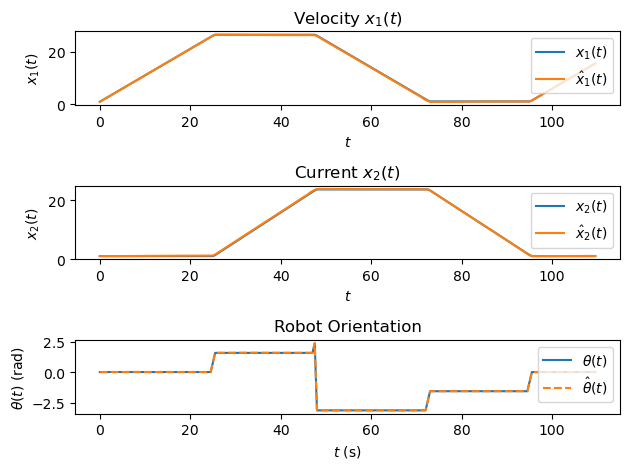

In [15]:
T = np.arange(0,N*Ts, Ts)


fig=plt.figure()
ax1=plt.subplot(3,1,1)
ax1.plot(T,pose_true[:,0],label=r'$x_1(t)$')
ax1.plot(T,pose_pred[:,0],label=r'$\hat{x}_1(t)$')
plt.xlabel("$t$")
plt.ylabel("$x_1(t)$")
plt.title("Velocity $x_1(t)$")
plt.legend(loc='upper right')

ax1=plt.subplot(3,1,2)
ax1.plot(T,pose_true[:,1],label=r'$x_2(t)$')
ax1.plot(T,pose_pred[:,1],label=r'$\hat{x}_2(t)$')
plt.xlabel("$t$")
plt.ylabel("$x_2(t)$")
plt.title("Current $x_2(t)$")
plt.legend(loc='upper right')

ax1 = plt.subplot(3, 1, 3)
ax1.plot(T, angle_wrap(pose_true[:, 2]), label=r'$\theta(t)$')  # Wrap true theta for comparison
ax1.plot(T, pose_pred[:, 2], label=r'$\hat{\theta}(t)$', linestyle='--')
plt.xlabel("$t$ (s)")
plt.ylabel(r"$\theta(t)$ (rad)")
plt.title("Robot Orientation")
plt.legend(loc='upper right')
# plt.grid(True)

fig.tight_layout()
plt.show()

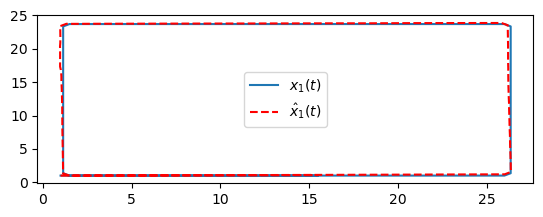

In [25]:
fig = plt.figure()
ax1=plt.subplot(2,1,1)
ax1.plot(pose_true[:,0],pose_true[:,1],label=r'$x_1(t)$')
ax1.plot(pose_pred[:,0],pose_pred[:,1],label=r'$\hat{x}_1(t)$', color='red', linestyle='--')
plt.legend(loc = 'center')
plt.show()


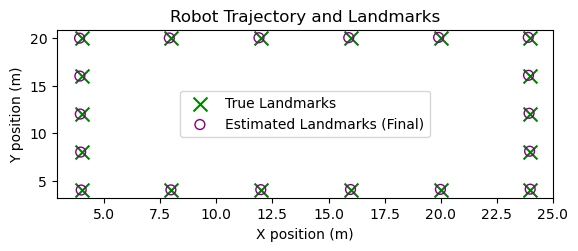

In [23]:
landmark_pred = landmark_pred.reshape(-1,2)

fig = plt.figure()
ax1=plt.subplot(2,1,1)
plt.scatter(Landmarks[:, 0], Landmarks[:, 1], label='True Landmarks', color='green', marker='x', s=100)

plt.scatter(landmark_pred[:, 0], landmark_pred[:, 1], label='Estimated Landmarks (Final)',
            color='purple', marker='o', s=50, facecolors='none')
# ax1.scatter(Landmarks[:,0],Landmarks[:,1],label=r'$x_1(t)$')
# ax1.scatter(landmark_pred[:,0],landmark_pred[:,1],label=r'$\hat{x}_1(t)$')
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.title("Robot Trajectory and Landmarks")
plt.legend()
# plt.axis('equal')
# plt.grid(True)
plt.show()
# plt.show()
